# [**Workflows for atomistic simulations**](http://potentials.rub.de/) 

## **Day 3 - Validation of various potentials**


### **Exercise 1: Validation of generated potentials using pyiron based workflows**

Before the excercise, you should:

* Have run the notebooks from day 1 and day2
* Be familiar with working with pyiron and the basics of potential fitting

The aim of this exercise is to make you familiar with:

* Potential validation techniques

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd

In [2]:
from pyiron import Project

In [3]:
pr = Project("validation")

In [4]:
# The list of potentials to iterate over

# The good potentials
potential_list = ['Cu-ace', 'Cu-runner']
# 

In [5]:
# Do Murnaghan, ElasticMatrix job, vac formation energy, binding energy, surface energies, comparison with dataset forces, energies

In [6]:
def clean_project_name(name):
    return name.replace("-", "_")

2021-03-08 15:26:13,689 - pyiron_log - WARNING - The job murn_job is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


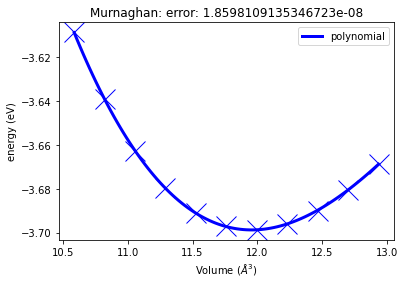

2021-03-08 15:26:15,280 - pyiron_log - WARNING - The job murn_job is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


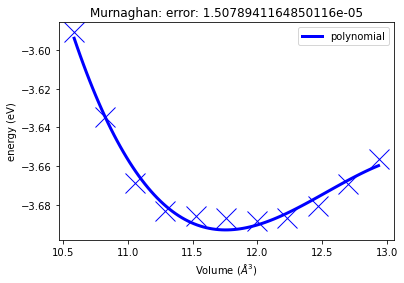

CPU times: user 3.05 s, sys: 1.73 s, total: 4.78 s
Wall time: 3.04 s


In [7]:
%%time
for pot in potential_list:
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(pot)
    job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, "ref_job")
    job_ref.structure = pr_pot.create_ase_bulk("Cu")
    job_ref.potential = pot
    job_ref.calc_minimize()
    murn_job = job_ref.create_job(pr_pot.job_type.Murnaghan, "murn_job")
    murn_job.run()
    murn_job.plot()

In [8]:
murn_job["output/equilibrium_energy"]

-3.6930468810926627

In [9]:
def get_only_murn(job_table):
    return job_table.hamilton == "Murnaghan"

def get_eq_vol(job_path):
    return job_path["output/equilibrium_volume"]

def get_eq_lp(job_path):
    return np.linalg.norm(job_path["output/structure/cell/cell"][0]) * np.sqrt(2)

def get_eq_bm(job_path):
    return job_path["output/equilibrium_bulk_modulus"]

def get_potential(job_path):
    return job_path["ref_job/input/potential/Name"]

def get_eq_energy(job_path):
    return job_path["output/equilibrium_energy"]

def get_n_atoms(job_path):
    return len(job_path["output/structure/positions"])

In [10]:
%%time
table = pr.create_table("table_murn", delete_existing_job=True)
table.db_filter_function = get_only_murn
table.add["potential"] = get_potential
table.add["a"] = get_eq_lp
table.add["eq_vol"] = get_eq_vol
table.add["eq_bm"] = get_eq_bm
table.add["eq_energy"] = get_eq_energy
table.add["n_atoms"] = get_n_atoms
table.run()
data_murn = table.get_dataframe()
data_murn

100%|██████████| 2/2 [00:00<00:00, 28.02it/s]

The job table_murn was saved and received the ID: 69
CPU times: user 188 ms, sys: 78.1 ms, total: 266 ms
Wall time: 299 ms


,job_id,potential,a,eq_vol,eq_bm,eq_energy,n_atoms
0,1,Cu-ace,3.629863,11.956678,146.220099,-3.698781,1
1,13,Cu-runner,3.609436,11.755954,181.669418,-3.693047,1


In [11]:
%%time
for pot in data_murn.potential.to_list():
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(pot)
    job_id = int(data_murn[data_murn.potential==pot].job_id)
    job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, "ref_job")
    job_ref.structure = pr_pot.inspect(job_id)["output/structure"].to_object()
    job_ref.potential = pot
    job_ref.calc_minimize()
    elastic_job = job_ref.create_job(pr_pot.job_type.ElasticMatrixJob, "elastic_job")
    elastic_job.input["eps_range"] = 0.05
    elastic_job.run()

2021-03-08 15:26:17,281 - pyiron_log - WARNING - The job elastic_job is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 15:26:18,342 - pyiron_log - WARNING - The job elastic_job is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


CPU times: user 2.3 s, sys: 1.2 s, total: 3.5 s
Wall time: 2.22 s


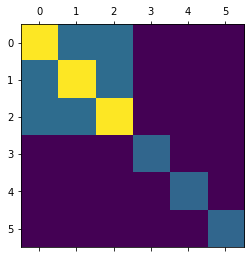

In [12]:
plt.matshow(elastic_job["output/elasticmatrix"]["C"]);

In [13]:
elastic_job["output/elasticmatrix"]["C"].flatten()

array([285.91475361, 100.57996064, 100.57996064,   0.        ,
         0.        ,   0.        , 100.57996064, 285.91475361,
       100.57996064,   0.        ,   0.        ,   0.        ,
       100.57996064, 100.57996064, 285.91475361,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  94.7567399 ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        94.7567399 ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  94.7567399 ])

In [14]:
def filter_elastic(job_table):
    return (job_table.hamilton == "ElasticMatrixJob") & (job_table.status == "finished")

def get_c11(job_path):
    return elastic_job["output/elasticmatrix"]["C"][0, 0]

def get_c12(job_path):
    return elastic_job["output/elasticmatrix"]["C"][0, 1]

def get_c44(job_path):
    return elastic_job["output/elasticmatrix"]["C"][3, 3]

In [15]:
%%time
table = pr.create_table("table_elastic", delete_existing_job=True)
table.db_filter_function = filter_elastic
table.add["potential"] = get_potential
table.add["C11"] = get_c11
table.add["C12"] = get_c12
table.add["C44"] = get_c44

table.run()
data_elastic = table.get_dataframe()
data_elastic

  0%|          | 0/2 [00:00<?, ?it/s]

The job table_elastic was saved and received the ID: 70


100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

CPU times: user 516 ms, sys: 109 ms, total: 625 ms
Wall time: 653 ms


,job_id,potential,C11,C12,C44
0,26,Cu-ace,285.914754,100.579961,94.75674
1,40,Cu-runner,285.914754,100.579961,94.75674


In [16]:
from structdbrest import StructDBLightRester
rest = StructDBLightRester(token="workshop2021")
fhi_calc = rest.query_calculator_types("FHI%aims%")[0]
dft_elast_prop = rest.query_properties(rest.PropertyTypes.ELASTIC_MATRIX, composition="Cu-%", strukturbericht="A1", 
                      calculator_name=fhi_calc.NAME)[0]

dft_phon_prop = rest.query_properties(rest.PropertyTypes.PHONONS, composition="Cu-%", strukturbericht="A1", 
                      calculator_name=fhi_calc.NAME)[0]

Querying...done
Response successful, size = 7.20 kB, time = 0.14 s
1  entries received
Querying...done
Response successful, size = 37.78 kB, time = 0.38 s
1  entries received
Querying...done
Response successful, size = 22.50 kB, time = 0.20 s
1  entries received


In [17]:
C_dft = dft_elast_prop.value["C"]
print("DFT C11={:.1f} GPa".format(C_dft[0][0]))
print("DFT C12={:.1f} GPa".format(C_dft[0][1]))
print("DFT C44={:.1f} GPa".format(C_dft[3][3]))

DFT C11=176.9 GPa
DFT C12=131.7 GPa
DFT C44=82.5 GPa


In [18]:
%%time

surface_type_list = ["fcc111", "fcc110", "fcc100"]

for i, pot in enumerate(data_murn.potential.to_list()):
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(group_name)
    a = data_murn.a.to_list()[i]
    for surface_type in surface_type_list:
        surface = pr.create_surface("Cu", surface_type=surface_type, size=(8, 8, 8), a=a, orthogonal=True, vacuum=12)
        job_lammps = pr_pot.create_job(pr_pot.job_type.Lammps, "surf_{}".format(surface_type))
        job_lammps.structure = surface
        job_lammps.potential = pot
        job_lammps.calc_minimize()
        job_lammps.run()

2021-03-08 15:26:21,384 - pyiron_log - WARNING - The job surf_fcc111 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 15:26:22,468 - pyiron_log - WARNING - The job surf_fcc110 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 15:26:23,551 - pyiron_log - WARNING - The job surf_fcc100 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 15:26:24,141 - pyiron_log - WARNING - Job aborted - please remove it and run again! surf_fcc111
/home/surendralal/programs/pyiron_base/pyiron_base/generic/parameters.py:283: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(
2021-03-08 15:26:24,696 - pyiron_log - WARNING - Job aborted - please remove it and run again! surf_fcc110


The job surf_fcc100 was saved and received the ID: 71


2021-03-08 15:26:26,236 - pyiron_log - WARNING - Job aborted
2021-03-08 15:26:26,238 - pyiron_log - WARNING - LAMMPS (10 Feb 2021)
Reading data file ...
  orthogonal box = (0.0000000 0.0000000 0.0000000) to (20.418051 20.418051 24.633024)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  512 atoms
  read_data CPU = 0.004 seconds

*******************************************************************************

WELCOME TO n²p², A SOFTWARE PACKAGE FOR NEURAL NETWORK POTENTIALS!
------------------------------------------------------------------

n²p² version      : 553e609
------------------------------------------------------------
Git branch        : HEAD
Git revision      : 553e6097553afe442843cc45bce5c974b1ec2f92
Compile date/time : Feb 15 2021 12:43:18
------------------------------------------------------------

Please cite the following papers when publishing results obtained with n²p²:
-------------------------------------------------------------------------------
 * General c

RuntimeError: Job aborted

In [19]:
# pot = "Cu-runner"
# group_name = clean_project_name(pot)
# pr_pot = pr.create_group(group_name)
# a = data_murn.a.to_list()[i]
# for surface_type in surface_type_list:
#     surface = pr.create_surface("Cu", surface_type=surface_type, size=(8, 8, 8), a=a, orthogonal=True, vacuum=12)
#     job_lammps = pr_pot.create_job(pr_pot.job_type.Lammps, "surf_{}".format(surface_type))
#     job_lammps.structure = surface
#     job_lammps.potential = pot
#     job_lammps.calc_minimize()
#     job_lammps.run()

In [20]:
pr_pot

{'groups': [], 'nodes': ['surf_fcc111', 'surf_fcc110', 'phonopy_job', 'surf_fcc100']}

In [21]:
surface.plot3d()

NGLWidget()

In [22]:
def is_a_surface(job_table):
    return (job_table.hamilton == "Lammps") & (job_table.job.str.contains("fcc")) & (job_table.status == "finished")

def get_potential_lammps_job(job_path):
    return job_path["input/potential/Name"]

def get_surface_type(job_path):
    surf_list =  ["fcc111", "fcc110", "fcc100"]
    conditions = [val in job_path.job_name for val in surf_list]
    return surf_list[np.where(conditions)[0].tolist()[0]]

def get_area(job_path):
    cell = job_path["output/structure/cell/cell"]
    return np.linalg.norm(np.cross(cell[0], cell[1]))

In [23]:
%%time
table = pr.create_table("table_surface", delete_existing_job=True)
table.db_filter_function = is_a_surface
table.add["potential"] = get_potential_lammps_job
table.add["surface_type"] = get_surface_type
table.add["surface_area"] = get_area
table.add.get_total_number_of_atoms

table.add.get_energy_tot
table.run()
data_surf = table.get_dataframe()
data_surf

100%|██████████| 3/3 [00:00<00:00, 37.06it/s]

The job table_surface was saved and received the ID: 72
CPU times: user 188 ms, sys: 62.5 ms, total: 250 ms
Wall time: 312 ms


,Number_of_atoms,job_id,energy_tot,potential,surface_type,surface_area
0,512,59,-1834.286336,Cu-ace,fcc111,365.141308
1,512,60,-1775.620101,Cu-ace,fcc110,596.273259
2,512,61,-1814.469585,Cu-ace,fcc100,421.628865


In [24]:
data_merged = pd.merge(data_surf, data_murn, on="potential")
data_merged

,Number_of_atoms,job_id_x,energy_tot,potential,surface_type,surface_area,job_id_y,a,eq_vol,eq_bm,eq_energy,n_atoms
0,512,59,-1834.286336,Cu-ace,fcc111,365.141308,1,3.629863,11.956678,146.220099,-3.698781,1
1,512,60,-1775.620101,Cu-ace,fcc110,596.273259,1,3.629863,11.956678,146.220099,-3.698781,1
2,512,61,-1814.469585,Cu-ace,fcc100,421.628865,1,3.629863,11.956678,146.220099,-3.698781,1


In [25]:
data_merged["surface_energy"] = data_merged.energy_tot - (data_merged.eq_energy * data_merged.Number_of_atoms)

In [26]:
data_merged["surface_energy_in_mJ_per_sq_m"] = data_merged.surface_energy / data_merged.surface_area / 2 * 16.0219 * 1e3

In [27]:
data_merged

,Number_of_atoms,job_id_x,energy_tot,potential,surface_type,surface_area,job_id_y,a,eq_vol,eq_bm,eq_energy,n_atoms,surface_energy,surface_energy_in_mJ_per_sq_m
0,512,59,-1834.286336,Cu-ace,fcc111,365.141308,1,3.629863,11.956678,146.220099,-3.698781,1,59.489333,1305.155196
1,512,60,-1775.620101,Cu-ace,fcc110,596.273259,1,3.629863,11.956678,146.220099,-3.698781,1,118.155568,1587.423774
2,512,61,-1814.469585,Cu-ace,fcc100,421.628865,1,3.629863,11.956678,146.220099,-3.698781,1,79.306085,1506.815901


## Finite temperature thermodynamics (Harmonic approximation)

In [28]:
# phonon DOS more analysis (comparison with some datasets)

In [29]:
%%time
for pot in data_murn.potential.to_list():
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(group_name)
    job_id = int(data_murn[data_murn.potential==pot].job_id)
    job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, "ref_job")
    job_ref.structure = pr_pot.inspect(job_id)["output/structure"].to_object()
    job_ref.potential = pot
    job_ref.calc_static()
    phonopy_job = job_ref.create_job(pr_pot.job_type.PhonopyJob, "phonopy_job")
    phonopy_job.run()

2021-03-08 15:26:28,415 - pyiron_log - WARNING - The job phonopy_job is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 15:26:29,746 - pyiron_log - WARNING - The job phonopy_job is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


CPU times: user 2.58 s, sys: 1.03 s, total: 3.61 s
Wall time: 2.63 s


In [30]:
pr

{'groups': ['Cu-ace', 'Cu-runner', 'Cu_ace', 'Cu_runner'], 'nodes': ['table_murn', 'table_elastic', 'table_surface']}

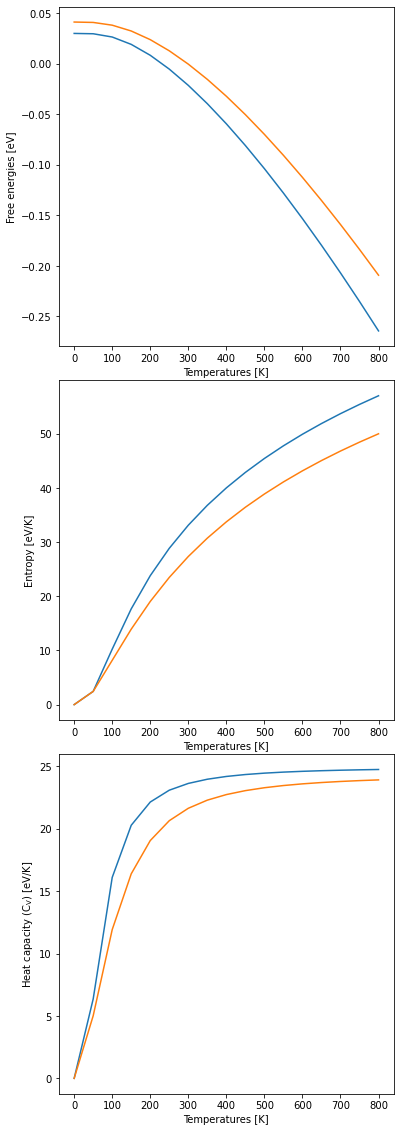

In [31]:
fig, ax_list = plt.subplots(ncols=1, nrows=3, sharex="row")
#fig.set_figwidth(20)
fig.set_figheight(20)


for i, pot in enumerate(potential_list):
    group_name = clean_project_name(pot)
    phonopy_job = pr[group_name+"/phonopy_job"]
    thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
    
    ax = ax_list[0]
    ax.plot(thermo.temperatures, thermo.free_energies)
    ax.set_xlabel("Temperatures [K]")
    ax.set_ylabel("Free energies [eV]")
    
    ax = ax_list[1]
    ax.plot(thermo.temperatures, thermo.entropy)
    ax.set_xlabel("Temperatures [K]")
    ax.set_ylabel("Entropy [eV/K]")
    
    ax = ax_list[2]
    ax.plot(thermo.temperatures, thermo.cv)
    ax.set_xlabel("Temperatures [K]")
    ax.set_ylabel("Heat capacity (C$_\mathrm{V}$) [eV/K]")
    
fig.subplots_adjust(hspace=0.1);    

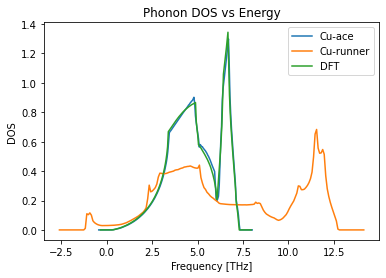

In [32]:
fig, ax = plt.subplots(ncols=1, nrows=1, sharex="row")

for i, pot in enumerate(potential_list):
    group_name = clean_project_name(pot)
    phonopy_job = pr[group_name+"/phonopy_job"]
    thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
    phonopy_job.plot_dos(label=pot, ax=ax)
ax.plot(dft_phon_prop.value["dos_energies"],  dft_phon_prop.value["dos_total"], label="DFT")
ax.legend()

## **Validating against datasets**

In [45]:
data_pr = Project("../datasets/imported_datasets")

data_pr.job_table()


,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,73,finished,None,df1_A1_A2_A3_EV_elast_phon,/df1_A1_A2_A3_EV_elast_phon,/home/surendralal/,notebooks/pyiron_potentialfit/datasets/imported_datasets/Cu_database/,2021-02-08 10:33:52.341472,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None
1,74,finished,None,df3_10k,/df3_10k,/home/surendralal/,notebooks/pyiron_potentialfit/datasets/imported_datasets/Cu_database/,2021-02-08 10:33:53.993230,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None
2,75,finished,None,df2_1k,/df2_1k,/home/surendralal/,notebooks/pyiron_potentialfit/datasets/imported_datasets/Cu_database/,2021-02-08 10:33:54.435308,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None


In [65]:
container = data_pr.load("df1_A1_A2_A3_EV_elast_phon")


In [66]:
training_dataset = container.to_pandas()

In [67]:
training_dataset

,name,atoms,energy,forces,number_of_atoms
0,A1:FHI-aims/PBE/tight:elastic:s_e_0,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.699843,"[[0.0, 0.0, 0.0]]",1.0
1,A1:FHI-aims/PBE/tight:murnaghan:strain_1_0,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.699841,"[[0.0, 0.0, 0.0]]",1.0
2,A1:FHI-aims/PBE/tight:phonon:supercell_phonon_0,"(Atom('Cu', [4.3368086899420173e-19, 0.007070999999999999, 0.007070999999999999], index=0), Atom('Cu', [3.3306690738754696e-16, 1.81563, 1.8156300000000005], index=1), Atom('Cu', [7.262518, 10.893...",-236.789603,"[[-1.13852957740976e-06, -0.0464638907314277, -0.0464636807741622], [-3.86335457040412e-06, 0.0124851330231607, 0.0124792943417333], [-1.94300535086066e-06, 6.63943441884098e-05, 6.92790474109119e...",64.0
3,A1:FHI-aims/PBE/tight:murnaghan:strain_1_02,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.697932,"[[0.0, 0.0, 0.0]]",1.0
4,A1:FHI-aims/PBE/tight:qha:murnaghan:strain_1_02,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.697932,"[[0.0, 0.0, 0.0]]",1.0
...,...,...,...,...,...
9995,ran2.10149,"(Atom('Cu', [0.0, 0.0, 0.0], index=0), Atom('Cu', [7.625348000000001, 2.638858, 8.690813], index=1))",-0.000158,"[[-0.000652878245165007, -0.000783544307315449, 0.00101172027652624], [0.000652878245165008, 0.000783544307315449, -0.00101172027652624]]",2.0
9996,ran1.706,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-0.000039,"[[0.0, 0.0, 0.0]]",1.0
9997,omegaca7,"(Atom('Cu', [6.599114000000002, 3.8100000000000005, 3.9726660000000003], index=0), Atom('Cu', [0.0, 0.0, 0.0], index=1), Atom('Cu', [8.881784197001252e-16, 7.620000000000001, 3.9726660000000003], ...",-0.000071,"[[1.40989781342388e-06, -0.000384028761549242, -6.97980275198934e-05], [1.25303887890355e-07, 1.18935395443782e-07, 0.000139596783714829], [-1.53520170131423e-06, 0.000383909826153798, -6.97987561...",3.0
9998,omega.shake.14,"(Atom('Cu', [6.9861320000000005, 4.124157, 3.6582539999999995], index=0), Atom('Cu', [13.307252, 0.6469480000000001, 8.183114], index=1), Atom('Cu', [0.17435200000000023, 7.436683, 3.775762], inde...",-0.000061,"[[0.00129020971805644, 0.00166221205053287, -0.000310382028586285], [-0.000648192115414079, 0.000636802014280741, -7.30090918109936e-05], [-0.000642017602642363, -0.00229901406481361, 0.0003833911...",3.0


In [51]:
structure_list, energy_list, force_list, num_atoms_list =  container.to_list()

energy_per_atom_list = np.array(energy_list) / np.array(num_atoms_list)


In [52]:
%%time
energy_pred_dict = dict()
force_pred_dict = dict()


for pot in potential_list:
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(pot)
    energy_pred_list = list()
    force_pred_list = list()
    
    stride = 10
    for i, struct in enumerate(structure_list[::stride]):
        job = pr_pot.create_job(pr.job_type.Lammps, "lammps_struct_{}".format(i))
        job.potential = pot
        job.structure = struct
        job.calc_static()
        job.run()
        energy_pred_list.append(job["output/generic/energy_tot"][-1] / len(struct))
        force_pred_list.append(job["output/generic/forces"][-1])
    job_box = pr_pot.create_job(pr.job_type.Lammps, "lammps_box")
    job_box.potential = pot
    job_box.structure = pr_pot.create_atoms("Cu", scaled_positions=[[0.5, 0.5, 0.5]], cell=np.eye(3)*10, pbc=True)
    job_box.calc_static()
    job_box.run()
    # correct for energy of isolated atom
    energy_pred_list = np.array(energy_pred_list) - job_box["output/generic/energy_tot"][-1]
    energy_pred_dict[pot] = energy_pred_list
    force_pred_dict[pot] = force_pred_list

The job lammps_struct_0 was saved and received the ID: 76
The job lammps_struct_1 was saved and received the ID: 77
The job lammps_struct_2 was saved and received the ID: 78
The job lammps_struct_3 was saved and received the ID: 79
The job lammps_struct_4 was saved and received the ID: 80
The job lammps_struct_5 was saved and received the ID: 81
The job lammps_struct_6 was saved and received the ID: 82
The job lammps_struct_7 was saved and received the ID: 83
The job lammps_struct_8 was saved and received the ID: 84
The job lammps_struct_9 was saved and received the ID: 85
The job lammps_struct_10 was saved and received the ID: 86
The job lammps_box was saved and received the ID: 87
The job lammps_struct_0 was saved and received the ID: 88
The job lammps_struct_1 was saved and received the ID: 89
The job lammps_struct_2 was saved and received the ID: 90
The job lammps_struct_3 was saved and received the ID: 91
The job lammps_struct_4 was saved and received the ID: 92
The job lammps_str

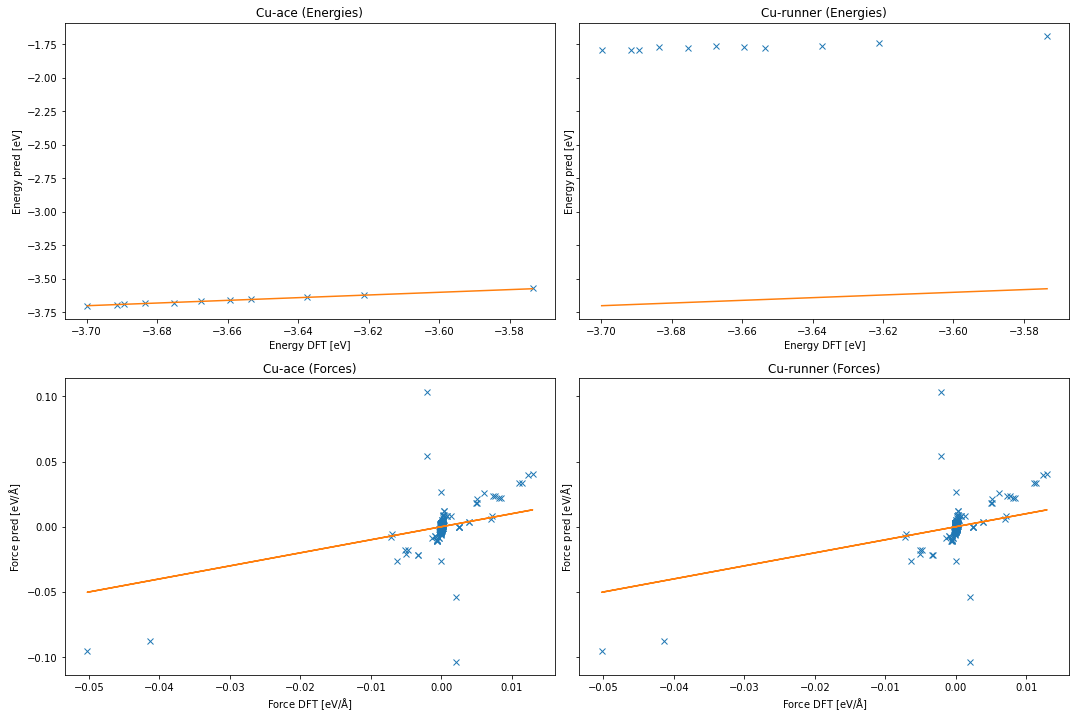

In [70]:
fig, ax_list = plt.subplots(ncols=len(potential_list), nrows=2, sharey="row", sharex="row")
fig.set_figwidth(18)
fig.set_figheight(12)

for i, (pot, energy_pred) in enumerate(energy_pred_dict.items()):
    
    ax = ax_list[0][i]
    ax.plot(energy_per_atom_list[::stride], energy_pred, "x")
    ax.plot(energy_per_atom_list[::stride], energy_per_atom_list[::stride])
    ax.set_title(pot + " (Energies)")
    ax.set_xlabel("Energy DFT [eV]")
    ax.set_ylabel("Energy pred [eV]")
    
    ax = ax_list[1][i]
    force_orig = np.hstack([f.flatten() for f in force_list[::stride]])
    force_pred = np.hstack([f.flatten() for f in force_pred_list])
    
    ax.plot(force_orig, force_pred, "x")
    ax.plot(force_orig, force_orig)
    ax.set_xlabel("Force DFT [eV/$\mathrm{\AA}$]")
    ax.set_ylabel("Force pred [eV/$\mathrm{\AA}$]")
    ax.set_title(pot + " (Forces)")
    
fig.subplots_adjust(wspace=0.05, hspace=0.2)
# ax.set_ylim(x_lim)